# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma than the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [34]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.optimize import brentq
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad
from scipy.optimize import minimize
from joblib import Parallel, delayed
from scipy.stats import rv_discrete
from statsmodels.stats.diagnostic import acorr_ljungbox
sns.set_style('darkgrid')

%run functions.py

In [20]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

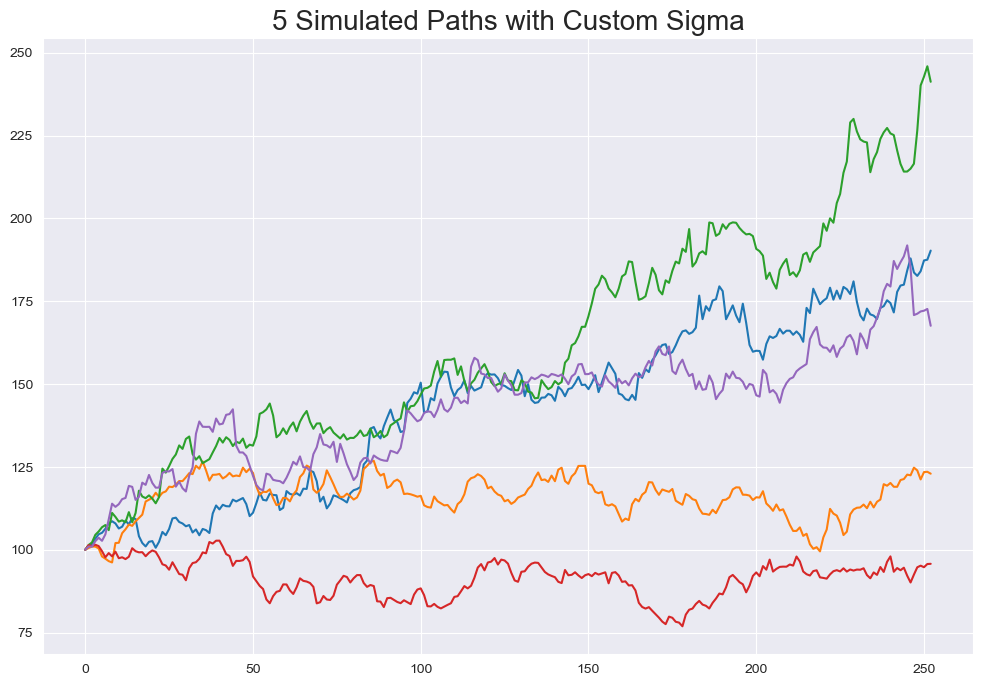

In [21]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

In [22]:
##Functions for option data obtained through y-finance

from dateutil import parser
from dateutil.tz import tzutc

def find_tte_yf_options(expiration_date,last_trade_date):
    '''returns time measured in years as a float between two dates
    
    Inputs:
    expiration_date (str): 'YYYY-MM-DD'
    last_trade_date (pandas._libs.tslibs.timestamps.Timestamp)
    
    Returns:
    Float of time to expiration in years
    '''
    tte = (datetime.datetime.strptime(expiration_date+'-21-30', "%Y-%m-%d-%H-%M").replace(tzinfo=tzutc()) -\
last_trade_date).total_seconds()/(60*60*24*365)
    
    return tte


def yf_find_approx_spot(stock_data, last_trade_date):
    """
    Finds approximate spot price at the time of last trade.
    The spot price is approximate since yfinance does not provide 1-second data, only minute-by-minute.

    Parameters:
    stock_data (pd.Series or pd.DataFrame): stock prices with DatetimeIndex
    last_trade_date (pd.Timestamp): timestamp of last trade of option contract

    Returns:
    float: approximate spot price, or NaN if unavailable
    """
    # Round timestamp to the minute (zero out seconds)
    ts = last_trade_date.replace(second=0)

    try:
        return stock_data.loc[ts].iloc[0]
    except KeyError:
        return float('nan')

In [23]:
def preprocessing(stock_symbol):
    ticker = yf.Ticker(stock_symbol)
    stock_data = yf.download(stock_symbol, period = '1d', interval = '1m')



    expirations = ticker.options


    #Create array to store options data
    option_data = []

    for date in expirations:
        chain = ticker.option_chain(date)

        # Add expiration and label
        calls = chain.calls.copy()
        calls['expiration'] = date
        calls['option_type'] = 'call'

        puts = chain.puts.copy()
        puts['expiration'] = date
        puts['option_type'] = 'put'

        option_data.append(calls)
        option_data.append(puts)

    # Combine all into one DataFrame and delete implied volatility column since we'll recalculate.
    options_data = pd.concat(option_data, ignore_index=True)
    options_data = options_data.drop(columns=['impliedVolatility'])


    #Delete any options that were traded in the interval of historical stock values obtained
    start_date = stock_data.index[0]
    options_data = options_data[options_data['lastTradeDate']>=start_date]


    #Insert column of time to expiration in years of the option contract measured from time of last trade
    options_data['time_to_expiration'] = options_data.apply(
    lambda row: find_tte_yf_options(expiration_date = row['expiration'],
                                last_trade_date = row['lastTradeDate']),
        axis = 1
    )


    #Add in column of the spot price of stock when the option trade occured.
    options_data['spot_price'] = options_data.apply(
        lambda row: yf_find_approx_spot(stock_data['Close'], row['lastTradeDate']),
        axis=1
    )
    options_data = options_data.dropna()





    #Create data frames that keeps relevant information and separate calls from puts.
    options_data = options_data[['strike', 'lastPrice', 'lastTradeDate',\
                                'expiration', 'option_type','time_to_expiration', 'spot_price']]
    options_data_calls = options_data[(options_data['option_type'] == 'call')].copy()
    options_data_puts = options_data[(options_data['option_type'] == 'put')].copy()



    #Add implied volatility column in calls data frame 
    r = 0.039
    options_data_calls['implied_volatility'] = options_data_calls.apply(
        lambda row: implied_volatility_call(
            market_price=row['lastPrice'],
            S0 = row['spot_price'],
            K=row['strike'],
            t=row['time_to_expiration'],
            r=r
        ),
        axis=1
    )


    #Add implied volatility column in puts data frame 
    options_data_puts['implied_volatility'] = options_data_puts.apply(
        lambda row: implied_volatility_put(
            market_price=row['lastPrice'],
            S0 = row['spot_price'],
            K=row['strike'],
            t=row['time_to_expiration'],
            r=r
        ),
        axis=1
    )

    #Remove rows with undefined values
    options_data_calls = options_data_calls.dropna()
    options_data_puts = options_data_puts.dropna()

    ## Remove additional rows if needed
    options_data_calls = options_data_calls[(options_data_calls['time_to_expiration']<=1)\
                                        & (options_data_calls['time_to_expiration']>=.5)]
    
    options_data_puts = options_data_puts[(options_data_puts['time_to_expiration']<=1)\
                                        & (options_data_puts['time_to_expiration']>=.5)]
    
    return options_data_calls, options_data_puts

In [33]:
def calibrate_call(options_data_calls):
    ###Calibrate Heston model to option data using gradient descent.

    def objective(params, option_data, r):
        kappa, theta, xi, rho, v0 = params
        
        error = 0
        for _, row in option_data.iterrows():
            model_price = heston_call(
                S0=row['spot_price'],
                K=row['strike'],
                v0=v0,
                r=r,
                t=row['time_to_expiration'],
                kappa=kappa,
                theta=theta,
                xi=xi,
                rho=rho
            )
            market_price = row['lastPrice']
            error += (model_price - market_price) ** 2
            
        return error / len(option_data)


    initial_guess = [1.0, 0.04, 0.3, -0.5, 0.04]  # kappa, theta, xi, rho, v0
    bounds = [(1e-4, 10), (1e-4, 1), (1e-4, 2), (-0.99, 0.99), (1e-4, 1)] 


    r = 0.039  

    result = minimize(
        objective,
        initial_guess,
        args=(options_data_calls, r),
        bounds=bounds,
        method='L-BFGS-B',
        options={
            'disp': True,
            'maxiter': 100,       
            'ftol': 1e-4,         
            'gtol': 1e-4          
        }
    )


    calibrated_params = result.x

    return calibrated_params

Now we apply these functions to see the distribution of profit of hedging with Heston model.

In [ ]:
# We use the stock of Google (GOOGL) to obtain the options data.
options_data_calls, _ = preprocessing('GOOGL')

/var/folders/7w/n7r483b55rb6kdsj5z4xsp4r0000gn/T/ipykernel_47969/616657582.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, period = '1d', interval = '1m')
[*********************100%***********************]  1 of 1 completed


In [55]:
options_data_calls.head(10)

,strike,lastPrice,lastTradeDate,expiration,option_type,time_to_expiration,spot_price,implied_volatility
828,65.0,110.75,2025-06-27 15:19:25+00:00,2026-01-16,call,0.556869,173.774994,0.704865
831,80.0,94.93,2025-06-27 18:36:48+00:00,2026-01-16,call,0.556494,172.669998,0.561010
833,90.0,85.90,2025-06-27 16:50:54+00:00,2026-01-16,call,0.556695,173.300003,0.505801
835,100.0,75.65,2025-06-27 18:19:04+00:00,2026-01-16,call,0.556528,172.604996,0.459583
839,120.0,57.35,2025-06-27 17:06:25+00:00,2026-01-16,call,0.556666,173.320007,0.373259
841,130.0,48.20,2025-06-27 18:40:12+00:00,2026-01-16,call,0.556487,172.660004,0.369868
842,135.0,49.20,2025-06-27 19:59:35+00:00,2026-01-16,call,0.556336,178.529999,0.363206
843,140.0,40.45,2025-06-27 16:54:40+00:00,2026-01-16,call,0.556688,173.334198,0.353160
844,145.0,40.80,2025-06-27 19:59:10+00:00,2026-01-16,call,0.556337,178.529999,0.345328
845,150.0,36.75,2025-06-27 19:59:17+00:00,2026-01-16,call,0.556337,178.529999,0.335560


In [ ]:
# We can select a specific row (839) to calibrate the Heston model.
row = options_data_calls.loc[839]

# Extract parameters for simulation
S0 = row['spot_price']
K = row['strike']
tte = row['time_to_expiration']
r = 0.039  # risk-free rate

print(f"Selected Option: Spot={S0:.2f}, Strike={K}, TTE={tte:.3f} years")

Selected Option: Spot=173.32, Strike=120.0, TTE=0.557 years


In [35]:
# Calibrated Heston parameters
kappa, theta, xi, rho, v0 = calibrate_call(options_data_calls)

# Simulation settings
n_steps = 100  # increase for finer hedge steps
n_sims = 3000
t = 100 / 252  # simulate until 100 trading days before expiration

# Simulate stock paths and volatilities
paths, vols = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, mu=0, n_sims=n_sims, return_vol=True)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57622D+01    |proj g|=  1.49000D+00


/Users/tzjsw/Downloads/Finance/Erdos-quant-finance/Erdos-summer-2025-quant-finance/functions.py:880: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
/Users/tzjsw/Downloads/Finance/Erdos-quant-finance/Erdos-summer-2025-quant-finance/functions.py:880: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P1 = 0.5 + (1 / np.pi) * quad(lambda phi: integrand(phi, 1), 0, 100)[0]
/Users/tzjsw/Downloads/Finance/Erdos-quant-finance/Erdos-summer-2025-quant-finance/functions.py:880: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the 


At iterate    1    f=  2.09111D+00    |proj g|=  1.72651D+00

At iterate    2    f=  8.30113D-01    |proj g|=  1.72207D+00

At iterate    3    f=  7.14310D-01    |proj g|=  1.06239D+00

At iterate    4    f=  7.12736D-01    |proj g|=  1.14332D+00

At iterate    5    f=  7.10362D-01    |proj g|=  1.21178D+00

At iterate    6    f=  7.02499D-01    |proj g|=  1.34538D+00

At iterate    7    f=  6.86313D-01    |proj g|=  1.48466D+00

At iterate    8    f=  6.54686D-01    |proj g|=  1.55195D+00

At iterate    9    f=  6.15924D-01    |proj g|=  1.33857D+00

At iterate   10    f=  5.92605D-01    |proj g|=  9.31580D-01

At iterate   11    f=  5.83593D-01    |proj g|=  9.21983D-01

At iterate   12    f=  5.77348D-01    |proj g|=  9.19544D-01

At iterate   13    f=  5.70200D-01    |proj g|=  9.16017D-01

At iterate   14    f=  5.56771D-01    |proj g|=  9.10905D-01

At iterate   15    f=  5.48405D-01    |proj g|=  9.12546D-01

At iterate   16    f=  5.42755D-01    |proj g|=  2.83275D-01

At iter

In [30]:
# Hedging with BS delta at each step
dt = t / n_steps
deltas = np.array([
    bs_call_delta(paths[:, i], K, np.sqrt(np.maximum(vols[:, i], 1e-10)), tte - i * dt, r)
    for i in range(n_steps)
]).T

# Hedging profit from stock
stock_profits_steps = (paths[:, 1:] - np.exp(r * dt) * paths[:, :-1]) * deltas * np.exp(-r * np.arange(1, n_steps + 1) * dt)
stock_profits = np.sum(stock_profits_steps, axis=1)


In [31]:
# Compute value of remaining option at time t using Heston formula
future_tte = tte - t
terminal_prices = paths[:, -1]
terminal_vols = vols[:, -1]

from joblib import Parallel, delayed

call_prices = Parallel(n_jobs=-1)(
    delayed(heston_call)(S, K, v, r, future_tte, kappa, theta, xi, rho)
    for S, v in zip(terminal_prices, terminal_vols)
)

# Final hedged portfolio value: option value - hedging cost
simulated_call_value = np.exp(-r * t) * np.array(call_prices) - stock_profits


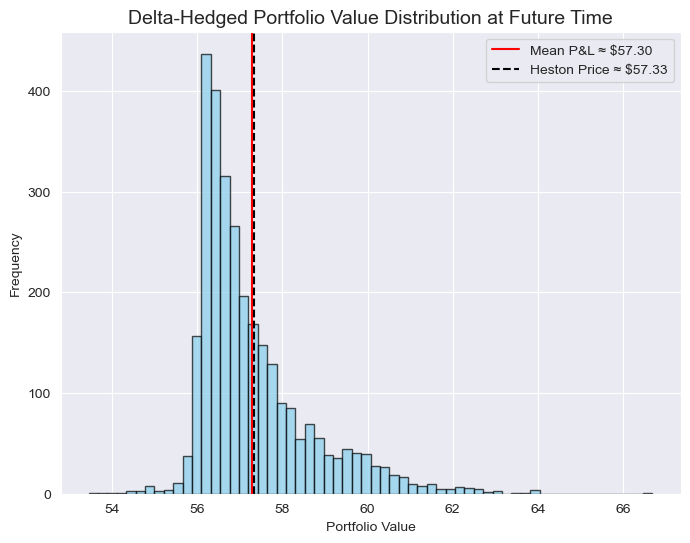

In [32]:
avg_value = np.mean(simulated_call_value)
fair_price = heston_call(S0, K, v0, r, tte, kappa, theta, xi, rho)

plt.figure(figsize=(8, 6))
plt.hist(simulated_call_value, bins=60, color='skyblue', edgecolor='k', alpha=0.7)
plt.axvline(avg_value, color='red', label=f"Mean P&L ≈ ${avg_value:.2f}")
plt.axvline(fair_price, color='black', linestyle='--', label=f"Heston Price ≈ ${fair_price:.2f}")
plt.title("Delta-Hedged Portfolio Value Distribution at Future Time", fontsize=14)
plt.xlabel("Portfolio Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


From the distribution, we can see that the average value of the delta-hedged portfolio $57.30 is close to the fair price of the option under the Heston model ($57.33). This suggests that the delta-hedging strategy is effective in managing risk and aligning with theoretical pricing.